# 14.2 합성곱 층

## 14.2.3 텐서플로 구현

In [1]:
# 정상동작을 위해 코드 추가
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

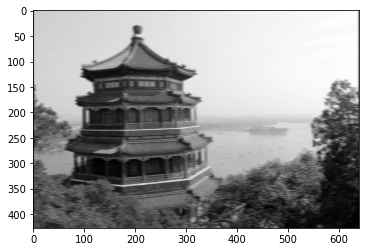

In [2]:
from sklearn.datasets import load_sample_image

# 샘플 이미지를 로드 합니다.
china  = load_sample_image("china.jpg")   / 255
flower = load_sample_image("flower.jpg")  / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# 필터를 2개 만듭니다.
filters = np.zeros(shape = (7, 7, channels, 2), dtype = np.float32)
filters[:, 3, :, 0] = 1 # 수직선
filters[3, :, :, 1] = 1 # 수평선

outputs = tf.nn.conv2d(images, filters, strides = 1, padding = "SAME")

plt.imshow(outputs[0, :, :, 1], cmap = "gray") # 첫 번째 이미지의 두 번재 특성 맵을 그립니다.
plt.show()

In [3]:
conv = keras.layers.Conv2D(filters = 32, kernel_size = 3, strides = 1,
                           padding = "same", activation = "relu")

# 14.3 풀링 층

## 14.3.1 텐서플로 구현

In [4]:
max_pool = keras.layers.MaxPool2D(pool_size = 2)

In [5]:
output = tf.nn.max_pool(images,
                        ksize = (1, 1, 1, 3),
                        strides = (1, 1, 1, 3),
                        padding = "valid")

InvalidArgumentError: ignored

In [6]:
output = tf.nn.max_pool(images,
                        ksize = (1, 1, 1, 3),
                        strides = (1, 1, 1, 3),
                        padding = "VALID") # valid = VALID

In [7]:
global_avg_pool = keras.layers.GlobalAvgPool2D()

# 14.4 CNN 구조

In [9]:
model = keras.models.Sequential([
                                 keras.layers.Conv2D(64, 7, activation = "relu", padding = "same", input_shape = [28, 28, 1]),
                                 keras.layers.MaxPooling2D(2),

                                 keras.layers.Conv2D(128, 3, activation = "relu", padding = "same"),
                                 keras.layers.Conv2D(128, 3, activation = "relu", padding = "same"),
                                 keras.layers.MaxPooling2D(2),

                                 keras.layers.Conv2D(256, 3, activation = "relu", padding = "same"),
                                 keras.layers.Conv2D(256, 3, activation = "relu", padding = "same"),
                                 keras.layers.MaxPooling2D(2),
                                 keras.layers.Flatten(),

                                 keras.layers.Dense(128, activation = "relu"),
                                 keras.layers.Dropout(0.5),

                                 keras.layers.Dense(64, activation = "relu"),
                                 keras.layers.Dropout(0.5),
                                 keras.layers.Dense(10, activation = "softmax")
])

# 14.5 케라스를 사용해 ResNet-34 CNN 구현하기

In [12]:
class ResidualUnit(keras.layers.Layer) :
  def __init__(self, filters, strides = 1, activation = "relu", **kwargs) :
    super().__init__(**kwargs)
    self.activation = keras.activations.get(activation)
    self.main_layers = [
                        keras.layers.Conv2D(filters, 3, strides = strides, padding = "same", use_bias = False),
                        keras.layers.BatchNormalization(),

                        self.activation,
                        keras.layers.Conv2D(filters, 3, strides = 1, padding = "same", use_bias = False),
                        keras.layers.BatchNormalization()
    ]
    self.skip_layers = []
    if strides > 1 :
      self.skip_layers = [
                          keras.layers.Conv2D(filters, 1, strides = strides, padding = "same", use_bias = False),
                          keras.layers.BatchNormalization()
      ]

  def call(self, inputs) :
    Z = inputs
    for layer in self.main_layers :
      Z = layer(Z)

    skip_Z = inputs
    for layer in self.skip_layers :
      skip_Z = layer(skip_Z)
    return self.activation(Z + skip_Z)

In [13]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, 7, strides = 2, input_shape = [224, 224, 3], padding = "same", use_bias = False))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size = 3, strides = 2, padding = "same"))

prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
  strides = 1 if filters == prev_filters else 2
  model.add(ResidualUnit(filters, strides = strides))
  prev_filters = filters

model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation = "softmax"))

# 14.6 케라스에서 제공하는 사전훈련된 모델 사용하기

In [14]:
model = keras.applications.resnet50.ResNet50(weights = "imagenet")

102973440/102967424 [==============================] - 4s 0us/step


In [15]:
images_resized = tf.image.resize(images, [224, 224])

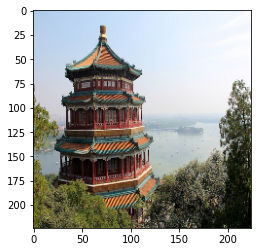

In [16]:
# 책에 없지만 이미지 참고를 위해 코드 추가
plt.imshow(images_resized[0])
plt.show()

In [17]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)

In [18]:
Y_proba = model.predict(inputs)

In [20]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top = 3)

for image_index in range(len(images)) :
  print("이미지 #{}".format(image_index))
  for class_id, name, y_proba in top_K[image_index] :
    print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
  print()

40960/35363 [==================================] - 0s 0us/step
이미지 #0
  n02825657 - bell_cote    82.35%
  n03877845 - palace       6.75%
  n03781244 - monastery    4.19%

이미지 #1
  n03530642 - honeycomb    49.83%
  n13040303 - stinkhorn    33.95%
  n02206856 - bee          4.35%



# 14.7 사전훈련된 모델을 사용한 전이 학습

In [21]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised = True, with_info = True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [22]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

In [23]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [25]:
n_classes = info.features["label"].num_classes
n_classes

5

In [26]:
test_split, valid_split, train_split = tfds.Split.TRAIN.subsplit([10, 15, 75])

test_set   = tfds.load("tf_flowers", split = test_split,  as_supervised = True)
valid_set  = tfds.load("tf_flowers", split = valid_split, as_supervised = True)
train_set  = tfds.load("tf_flowers", split = train_split, as_supervised = True)

AttributeError: ignored

In [29]:
# 에러나는 위 코드를 아래 코드로 대체

test_set, valid_set, train_set = tfds.load(
    name  = "tf_flowers",
    split = ('train[:10%]', 'train[10%:25%]', 'train[25%:]'),
    as_supervised = True
)

In [30]:
def preprocess(image, label) :
  resized_image = tf.image.resize(image, [224, 224])
  final_image = keras.applications.xception.preprocess_input(resized_image)
  return final_image, label

In [31]:
batch_size = 32
train_set = train_set.shuffle(1000)

train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set.map(preprocess).batch(batch_size).prefetch(1)
test_set  = test_set.map(preprocess).batch(batch_size).prefetch(1)

In [32]:
base_model = keras.applications.xception.Xception(weights = "imagenet", include_top = False)

avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation = "softmax")(avg)
model = keras.models.Model(inputs = base_model.input, outputs = output)

83689472/83683744 [==============================] - 3s 0us/step


In [33]:
for layer in base_model.layers:
  layer.trainable = False

In [34]:
optimizer = keras.optimizers.SGD(lr = 0.2, momentum = 0.9, decay = 0.01)
model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])

history = model.fit(train_set, epochs = 2, validation_data = valid_set) # epochs = 5 -> 2 로 수정 (회차당 약 600초 소요) 실습 속도를 위함

Epoch 1/2
86/86 [==============================] - 584s 7s/step - loss: 1.1943 - accuracy: 0.7954 - val_loss: 1.4330 - val_accuracy: 0.7985
Epoch 2/2
86/86 [==============================] - 582s 7s/step - loss: 0.4989 - accuracy: 0.9081 - val_loss: 0.8927 - val_accuracy: 0.8730


In [35]:
for layer in base_model.layers:
  layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9, nesterov = True, decay = 0.001)
model.compile(loss = "sparse_categorical_crossentropy", optimizer = optimizer, metrics = ["accuracy"])

history = model.fit(train_set, epochs = 1, validation_data = valid_set) # epochs = 40 -> 1 로 수정 (회차당 약 2300초 소요) 실습 속도를 위함

86/86 [==============================] - 1987s 23s/step - loss: 0.3749 - accuracy: 0.8772 - val_loss: 0.4849 - val_accuracy: 0.8875


# 14.8 분류와 위치 추정

In [37]:
base_model = keras.applications.xception.Xception(weights = "imagenet", include_top = False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)

class_output = keras.layers.Dense(n_classes, activation = "softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)

model = keras.models.Model(inputs = base_model.input, outputs = [class_output, loc_output])
model.compile(loss = ["sparse_categorical_crossentropy", "mse"],
              loss_weights = [0.8, 0.2], # 어떤 것을 중요하게 생각하느냐에 따라
              optimizer = optimizer, 
              metrics = ["accuracy"])